In [1]:
import os
import re
import ants
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [2]:
METADATADIR = os.path.join("/DATA", "ABCDFixRelease")
METADATADIRv4 = os.path.join("/DATA", "ABCD 4.0 Spreadsheets")
TASKDIR = "/DATA/ABCDTasks"

In [3]:
fs_qc_raw = pd.read_csv(f"{METADATADIR}/freesqc01.txt", sep="\t", skiprows=[1])
t2_qc = pd.read_csv(f"{METADATADIRv4}/abcd_t2wqc01.txt", sep="\t", skiprows=[1], usecols=["subjectkey", "t2w_postqc_qc"])
qc_raw = fs_qc_raw.merge(t2_qc, how="inner", on="subjectkey")
qc_raw.shape, qc_raw["subjectkey"].unique().shape

((18309, 23), (11238,))

In [4]:
t2_qc.t2w_postqc_qc.notna().sum(), t2_qc.query("t2w_postqc_qc != 0").t2w_postqc_qc.sum()

(541, 447.0)

In the t2w_postqc_qc 0 = reject ; 1 = accept according to https://nda.nih.gov/data_structure.html?short_name=abcd_t2wqc01

In [5]:
passed_all = qc_raw.query("eventname == 'baseline_year_1_arm_1' & \
                           fsqc_qc == 1 & fsqc_qu_pialover < 2 & fsqc_qu_wmunder < 2 & \
                           fsqc_qu_motion == 0 & fsqc_qu_artifact == 0 & t2w_postqc_qc != 0")
passed_all.shape

(7170, 23)

In [6]:
mri_raw = pd.read_csv(f"{METADATADIR}/abcd_mri01.txt", sep="\t", skiprows=[1])

final_qc = mri_raw[["subjectkey", "mri_info_deviceserialnumber"]].merge(passed_all, how="inner", on="subjectkey")
scanner_counts = final_qc["mri_info_deviceserialnumber"].value_counts()
scanner_qc = scanner_counts[scanner_counts > 20].index
final_qc = final_qc[final_qc["mri_info_deviceserialnumber"].isin(scanner_qc)]
final_qc.shape

(7166, 24)

## Save selected subject IDs

> **INTERSECT WITH SUBJECTS THAT WE ACTUALLY HAVE ON DISK!!!**

In [7]:
import glob
R = re.compile(r"Data\/sub-(.*)\/ses-")
clean = lambda x: x.strip().replace("_", "")
t1_paths = glob.glob("/DATA/ImageData/Data/*/ses-baselineYear1Arm1/anat/*T1w.nii.gz")
t2_paths = glob.glob("/DATA/ImageData/Data/*/ses-baselineYear1Arm1/anat/*T2w.nii.gz")

In [8]:
_fn = lambda x: R.search(x).group(1).replace("NDAR", "NDAR_")
t1_ids = set(map(_fn, t1_paths))
t2_ids = set(map(_fn, t2_paths))
subject_ids = t1_ids.intersection(t2_ids)

In [9]:
t1_paths[:3]

['/DATA/ImageData/Data/sub-NDARINVVM3WVMV7/ses-baselineYear1Arm1/anat/sub-NDARINVVM3WVMV7_ses-baselineYear1Arm1_run-01_T1w.nii.gz',
 '/DATA/ImageData/Data/sub-NDARINVCDNAUD1U/ses-baselineYear1Arm1/anat/sub-NDARINVCDNAUD1U_ses-baselineYear1Arm1_run-01_T1w.nii.gz',
 '/DATA/ImageData/Data/sub-NDARINV1ZZAPY9K/ses-baselineYear1Arm1/anat/sub-NDARINV1ZZAPY9K_ses-baselineYear1Arm1_run-01_T1w.nii.gz']

In [10]:
len(t1_ids), len(t2_ids), len(subject_ids)

(3881, 3790, 3788)

In [11]:
final_qc["subjectkey"].shape

(7166,)

In [12]:
final_qc_keys = final_qc["subjectkey"].drop_duplicates()
final_qc_keys.shape

(4601,)

In [13]:
on_disk = final_qc_keys.isin(subject_ids)
on_disk.shape

(4601,)

In [14]:
inlier_keys = final_qc_keys[on_disk]
inlier_keys.shape

(1371,)

In [15]:
abcd_qc_passing_keys = inlier_keys
abcd_qc_passing_keys.shape

(1371,)

In [16]:
len(abcd_qc_passing_keys.unique())

1371

## After WM Segmentations

In [17]:
save_dir = "/DATA/Users/amahmood/braintyp/segs/"
seg_paths = glob.glob(f"{save_dir}/NDAR*.npz")

In [18]:
%%time
t1_wm = []
t2_wm = []

for p in seg_paths:
    with np.load(p) as f:
        t1_wm.append(f['t1'])
        t2_wm.append(f['t2'])

CPU times: user 27.4 s, sys: 2.42 s, total: 29.9 s
Wall time: 31.5 s


In [19]:
re.search(r"(NDAR.*).npz",seg_paths[0]).group(1)

'NDARINV7ZE3WGCX'

In [20]:
subids = [re.search(r"(NDAR.*).npz", p).group(1) for p in seg_paths]

In [21]:
assert len(subids) == len(abcd_qc_passing_keys)

In [22]:
t1_wm_means = pd.Series(np.array([x.mean() for x in t1_wm]), index=subids)
t2_wm_means = pd.Series(np.array([x.mean() for x in t2_wm]), index=subids)

In [23]:
t1_wm_stds = pd.Series(np.array([x.std() for x in t1_wm]), index=subids)
t2_wm_stds = pd.Series(np.array([x.std() for x in t2_wm]), index=subids)

count    1371.000000
mean        0.865099
std         0.042438
min         0.009469
25%         0.855540
50%         0.873478
75%         0.888241
max         0.939414
dtype: float64

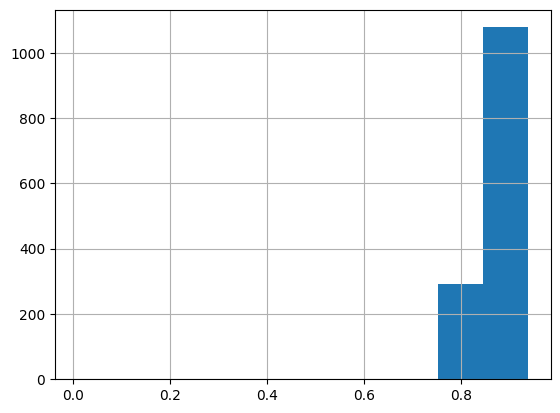

In [24]:
t1_wm_means.hist()
t1_wm_means.describe()

count    1371.000000
mean        0.044052
std         0.008849
min         0.019418
25%         0.038065
50%         0.046700
75%         0.050825
max         0.061637
dtype: float64

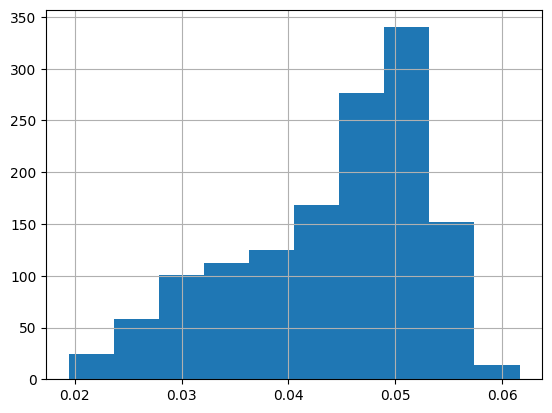

In [25]:
t1_wm_stds.hist()
t1_wm_stds.describe()

In [26]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.865 w/ std 0.042


In [27]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.044 w/ std 0.009


In [28]:
mult = 3
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

1

In [29]:
# t1_candidates = (t1_wm_means > (means_mu + 3*means_std)) | (t1_wm_means < (means_mu - 3*means_std))
# t1_outliers = list(np.argwhere(t1_candidates.to_numpy()).flatten())
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

1371

In [30]:
t1_wm_means[t1_outliers]

NDARINVV1F9DNZH    0.009469
dtype: float32

NDARINVV1F9DNZH: /DATA/ImageData/Data/sub-NDARINVV1F9DNZH/ses-baselineYear1Arm1/anat/sub-NDARINVV1F9DNZH_ses-baselineYear1Arm1_run-01_T1w.nii.gz


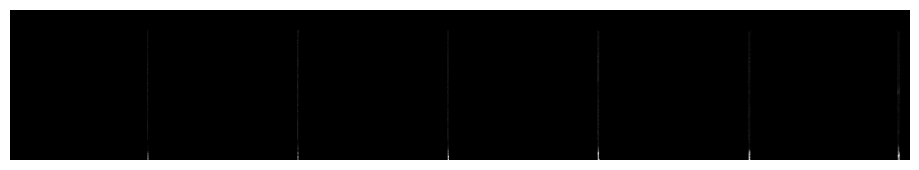

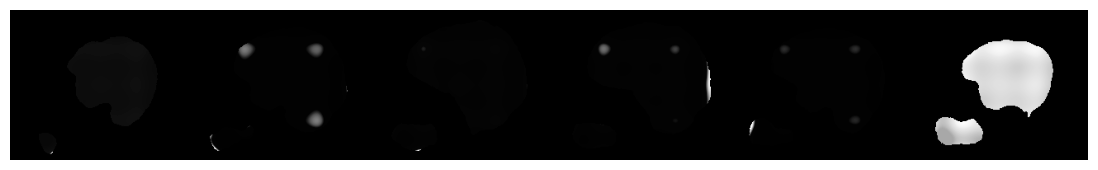

In [31]:
for tidx in t1_outliers:
    sid = t1_wm_means.index[tidx]
    path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz"
    print(f"{sid}: {path}")
    preproc_path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
#     print(f"{sid}: {path}")

    t1_outlier_img = ants.image_read(path)
    t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd,_ = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6)

### T2

count    1371.000000
mean        0.573386
std         0.032673
min         0.486719
25%         0.554836
50%         0.570660
75%         0.586823
max         0.817917
dtype: float64

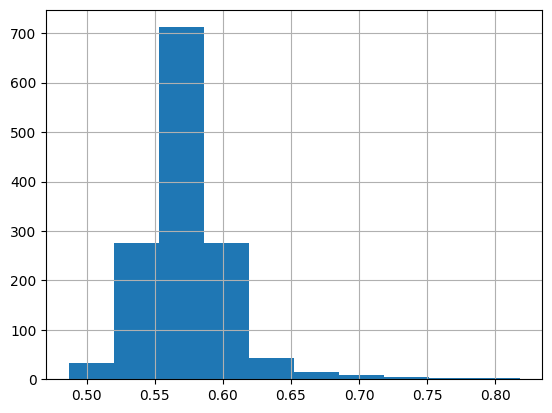

In [32]:
t2_wm_means.hist()
t2_wm_means.describe()

In [33]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [34]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.573 w/ std 0.033


In [35]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.057 w/ std 0.013


In [36]:
mult = 3
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

28

In [37]:
sorted_t2 = t2_wm_means[t2_outliers].sort_values(ascending=False)
sorted_t2

NDARINVGLRTPTNN    0.817917
NDARINVEPV33CZJ    0.795969
NDARINV6UU2L6YJ    0.786638
NDARINVP5DWFRD0    0.782934
NDARINVELUYAFWW    0.756556
NDARINV2LUG79YV    0.745846
NDARINVED4GJ51W    0.738232
NDARINVCTM83NPV    0.729256
NDARINVNXU172XX    0.719588
NDARINV3MLPX0CG    0.719051
NDARINV8GZUK8EV    0.715563
NDARINV8MRME9FG    0.712532
NDARINVA4MH2U9C    0.711713
NDARINV61X565FX    0.708416
NDARINV21EBHGF9    0.701630
NDARINVGWF3GZ8C    0.697736
NDARINV7ZVJYLM3    0.694115
NDARINV5VMC4WL1    0.691728
NDARINV5ZHBV7HD    0.684193
NDARINV8M2Z9BTA    0.683729
NDARINVH5WAU70T    0.682024
NDARINVM0JXYXX1    0.676011
NDARINV9ZXTBCKF    0.675843
NDARINV95V2LL1W    0.674527
NDARINVX24GH2TJ    0.673876
NDARINVHJ7JV8XN    0.673190
NDARINV7X4CGXMP    0.672884
NDARINVV1F9DNZH    0.570060
dtype: float32

NDARINVGLRTPTNN: /DATA/ImageData/Data/sub-NDARINVGLRTPTNN/ses-baselineYear1Arm1/anat/sub-NDARINVGLRTPTNN_ses-baselineYear1Arm1_run-01_T1w.nii.gz


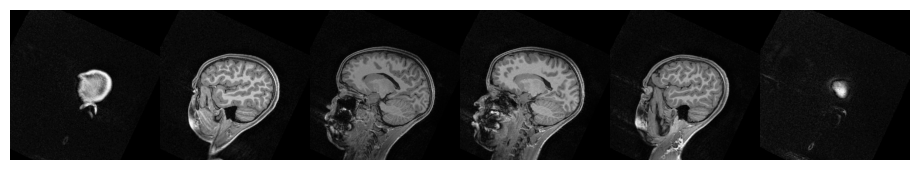

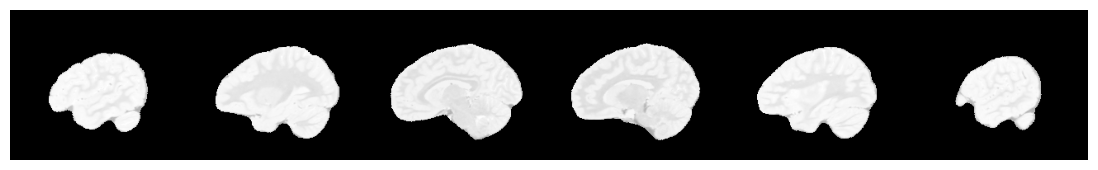

NDARINVEPV33CZJ: /DATA/ImageData/Data/sub-NDARINVEPV33CZJ/ses-baselineYear1Arm1/anat/sub-NDARINVEPV33CZJ_ses-baselineYear1Arm1_run-01_T1w.nii.gz


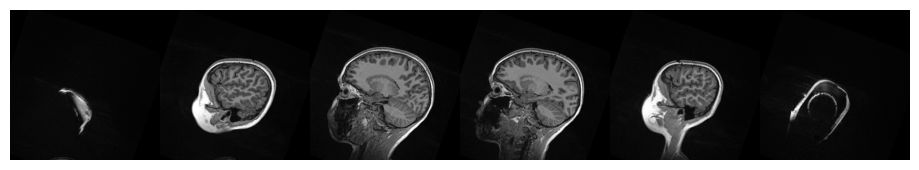

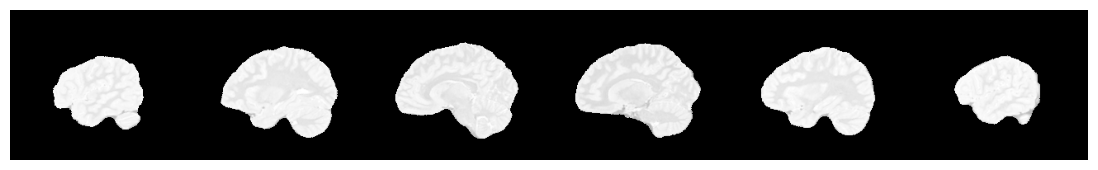

NDARINV6UU2L6YJ: /DATA/ImageData/Data/sub-NDARINV6UU2L6YJ/ses-baselineYear1Arm1/anat/sub-NDARINV6UU2L6YJ_ses-baselineYear1Arm1_run-01_T1w.nii.gz


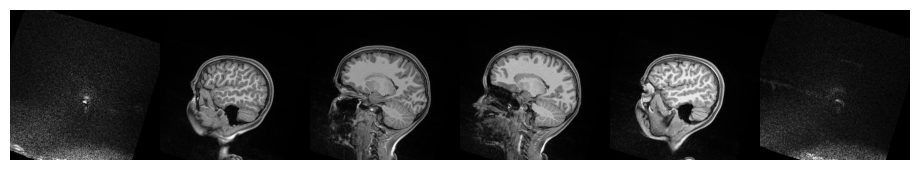

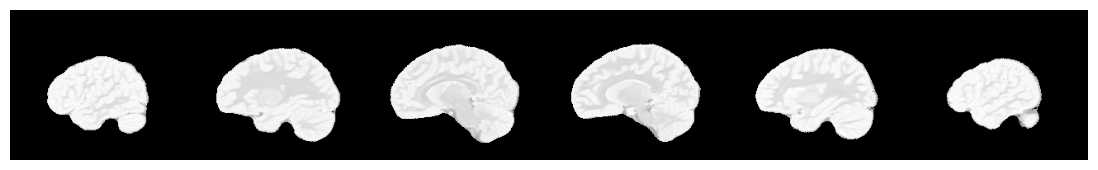

In [38]:
for sid in sorted_t2.index[:3]:
    path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz"
    print(f"{sid}: {path}")
    preproc_path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
#     print(f"{sid}: {path}")

    t2_outlier_img = ants.image_read(path)
    t2_outlier_img.plot(nslices=6)
    
    _, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t2_outlier_img_procd.plot(nslices=6,)

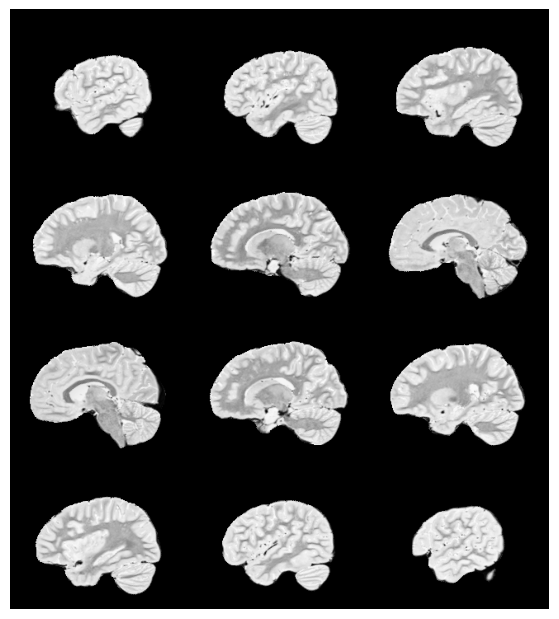

In [39]:
t2_median_idx = t2_wm_means.sort_values(ascending=False).index[len(t2_wm_means)//2]
path = f"/DATA/Users/amahmood/braintyp/processed_v2/{t2_median_idx}.nii.gz"
t2med_t1_img, t2_median_img = ants.image_read(path).split_channels()
t2_median_img.plot()

In [40]:
# for sid in t2_wm_means[t2_outliers].index:
#     print(sid)
#     path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
#     t2out_t1_img, t2_outlier_img = ants.image_read(path).split_channels()
#     t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/t2_{sid}.nii.gz"
#     t2_outlier_img.to_filename(t2_viz_path)

In [41]:
t2_wm_means[t2_outliers].sort_values(ascending=False)

NDARINVGLRTPTNN    0.817917
NDARINVEPV33CZJ    0.795969
NDARINV6UU2L6YJ    0.786638
NDARINVP5DWFRD0    0.782934
NDARINVELUYAFWW    0.756556
NDARINV2LUG79YV    0.745846
NDARINVED4GJ51W    0.738232
NDARINVCTM83NPV    0.729256
NDARINVNXU172XX    0.719588
NDARINV3MLPX0CG    0.719051
NDARINV8GZUK8EV    0.715563
NDARINV8MRME9FG    0.712532
NDARINVA4MH2U9C    0.711713
NDARINV61X565FX    0.708416
NDARINV21EBHGF9    0.701630
NDARINVGWF3GZ8C    0.697736
NDARINV7ZVJYLM3    0.694115
NDARINV5VMC4WL1    0.691728
NDARINV5ZHBV7HD    0.684193
NDARINV8M2Z9BTA    0.683729
NDARINVH5WAU70T    0.682024
NDARINVM0JXYXX1    0.676011
NDARINV9ZXTBCKF    0.675843
NDARINV95V2LL1W    0.674527
NDARINVX24GH2TJ    0.673876
NDARINVHJ7JV8XN    0.673190
NDARINV7X4CGXMP    0.672884
NDARINVV1F9DNZH    0.570060
dtype: float32

In [42]:
# for i, sid in enumerate(t2_wm_means.drop(index=t2_wm_means[t2_outliers].index).index):
#     print(sid)
#     path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
#     t2out_t1_img, t2_outlier_img = ants.image_read(path).split_channels()
#     t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_inliers/ABCD_{sid}.nii.gz"
#     t2_outlier_img.to_filename(t2_viz_path)
    
#     if i > 5:
#         break

In [43]:
# for sid in t2_wm_means[t2_outliers].sort_values(ascending=False).index:
#     print(sid)
# #     path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz"
# #     t2_outlier_img = ants.image_read(path)
#     path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
#     t2out_t1_img, t2_outlier_img = ants.image_read(path).split_channels()
# #     t2_outlier_img.plot()
#     t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/t2_{sid}.nii.gz"
#     t2_outlier_img.to_filename(t2_viz_path)

use mriwatcher on ondemand

# Final set of cleaned keys!

In [44]:
wm_outlier_keys = set(x.replace("NDAR", "NDAR_") for x in t1_wm_means[t1_outliers].index)

handpicked_outliers = ["NDARINV8M2Z9BTA", "NDARINVV1F9DNZH", "NDARINV5VMC4WL1",
                       "NDARINVX24GH2TJ","NDARINVM0JXYXX1", "NDARINVP5DWFRD0"]
handpicked_outliers = set(x.replace("NDAR", "NDAR_") for x in handpicked_outliers)
wm_outlier_keys = wm_outlier_keys.union(handpicked_outliers)
len(wm_outlier_keys)

6

In [45]:
abcd_wm_qc_passing_keys = abcd_qc_passing_keys[~abcd_qc_passing_keys.isin(wm_outlier_keys)]
abcd_wm_qc_passing_keys.shape

(1365,)

In [46]:
abcd_wm_qc_passing_keys.to_csv("abcd_wm_qc_passing_keys.txt", header=None, index=None)